<a href="https://colab.research.google.com/github/rbhargava03/neuro140FinalProject/blob/main/SpaceObjectID_NeuralNetwork_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

<ipython-input-2-d2dcf17c2c7c>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sizes = [label_counts.get(1, 0), label_counts.get(0, 0)]


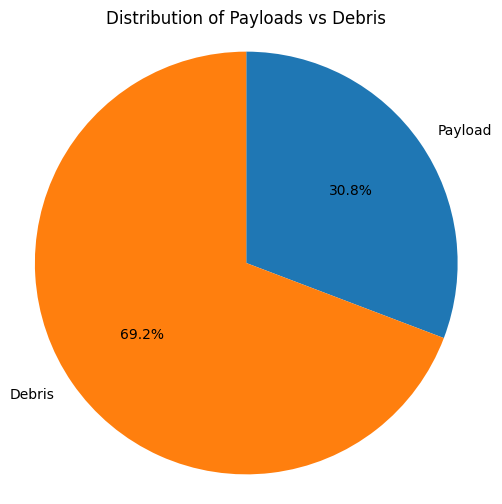

In [ ]:
# load data and examine distribution
file_path = "/content/drive/MyDrive/Harvard/SpaceObjectIDProject/PayloadDebrisData.csv"
df = pd.read_csv(file_path)

# clean data
def convert_label(x):
    x = str(x).strip().upper()
    if x == "PAYLOAD":
        return 1
    elif x == "DEBRIS":
        return 0
    return np.nan
#count amount of objects in each type
label_counts = df["OBJECT_TYPE"].value_counts()

#make an plot pie chart with data distribution
labels = ["Payload", "Debris"]
sizes = [label_counts.get(1, 0), label_counts.get(0, 0)]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, counterclock=False)
plt.title("Distribution of Payloads vs Debris")
plt.axis("equal")
plt.show()

In [ ]:
# neural network split and implementaton

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ["PERIOD", "INCLINATION", "APOGEE", "PERIGEE"]
df["OBJECT_TYPE"] = df["OBJECT_TYPE"].apply(convert_label)
df.dropna(subset=features + ["OBJECT_TYPE"], inplace=True)

# split/ sclae data
X = df[features].values
y = df["OBJECT_TYPE"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# pytorch dataset
class OrbitalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(OrbitalDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(OrbitalDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(OrbitalDataset(X_test, y_test), batch_size=32)

# MODEL
class OrbitalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OrbitalClassifier().to(device)

#class balancing:
class_counts = np.bincount(y_train.astype(int))
pos_weight = torch.tensor([class_counts[0] / class_counts[1]], dtype=torch.float32).to(device)

# setup loss + itemizer
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
nb_epochs = 300

# For plotting
train_acc_history = []
val_acc_history = []
val_f1_payload_history = []

for epoch in range(nb_epochs):
    model.train()
    train_losses, train_accuracies = [], []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds = (torch.sigmoid(y_pred) > 0.5).float()
        acc = (preds == y_batch).float().mean().item()
        train_accuracies.append(acc)

    avg_train_acc = np.mean(train_accuracies)
    train_acc_history.append(avg_train_acc)

    # validation phase
    model.eval()
    val_losses, val_accuracies = [], []
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            val_losses.append(loss.item())

            preds = (torch.sigmoid(y_pred) > 0.5).float()
            acc = (preds == y_batch).float().mean().item()
            val_accuracies.append(acc)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(y_batch.cpu().numpy())

    avg_val_acc = np.mean(val_accuracies)
    val_acc_history.append(avg_val_acc)

    # payload F1 Score (label=1)
    f1_payload = f1_score(all_val_labels, all_val_preds, pos_label=1)
    val_f1_payload_history.append(f1_payload)

    print(f"Epoch {epoch+1}, "
          f"Train Acc: {avg_train_acc:.4f}, "
          f"Val Acc: {avg_val_acc:.4f}, "
          f"Payload F1: {f1_payload:.4f}")


Epoch 1, Train Acc: 0.5816, Val Acc: 0.7470, Payload F1: 0.5558
Epoch 2, Train Acc: 0.7474, Val Acc: 0.7584, Payload F1: 0.5570
Epoch 3, Train Acc: 0.7641, Val Acc: 0.7667, Payload F1: 0.5622
Epoch 4, Train Acc: 0.7686, Val Acc: 0.7697, Payload F1: 0.5658
Epoch 5, Train Acc: 0.7710, Val Acc: 0.7697, Payload F1: 0.5631
Epoch 6, Train Acc: 0.7720, Val Acc: 0.7711, Payload F1: 0.5703
Epoch 7, Train Acc: 0.7738, Val Acc: 0.7707, Payload F1: 0.5679
Epoch 8, Train Acc: 0.7734, Val Acc: 0.7704, Payload F1: 0.5659
Epoch 9, Train Acc: 0.7742, Val Acc: 0.7732, Payload F1: 0.5667
Epoch 10, Train Acc: 0.7748, Val Acc: 0.7735, Payload F1: 0.5699
Epoch 11, Train Acc: 0.7686, Val Acc: 0.7842, Payload F1: 0.6039
Epoch 12, Train Acc: 0.7681, Val Acc: 0.7818, Payload F1: 0.6127
Epoch 13, Train Acc: 0.7675, Val Acc: 0.7739, Payload F1: 0.6093
Epoch 14, Train Acc: 0.7641, Val Acc: 0.7820, Payload F1: 0.6165
Epoch 15, Train Acc: 0.7665, Val Acc: 0.7923, Payload F1: 0.6501
Epoch 16, Train Acc: 0.7663, Val A

In [ ]:
# Get final scores
from sklearn.metrics import classification_report

# get all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# print F1, precision, recall in a table
print(classification_report(all_labels, all_preds, target_names=["Debris", "Payload"]))


              precision    recall  f1-score   support

      Debris       0.91      0.91      0.91      5224
     Payload       0.79      0.79      0.79      2168

    accuracy                           0.88      7392
   macro avg       0.85      0.85      0.85      7392
weighted avg       0.88      0.88      0.88      7392



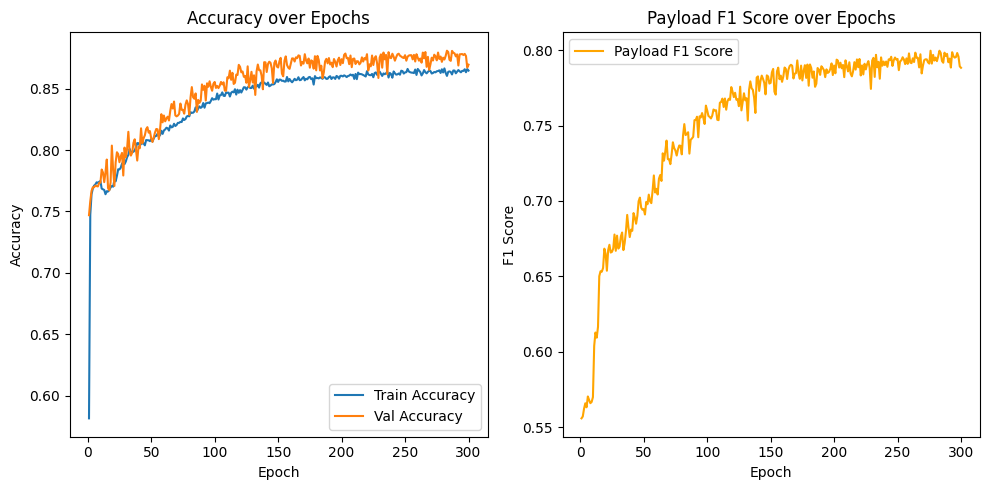

In [ ]:
#print accuracy and f1 score over time for the nueral network (helpful to see plateau)

epochs = range(1, 300 + 1)

plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# payload F1 Score plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1_payload_history, color='orange', label='Payload F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Payload F1 Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


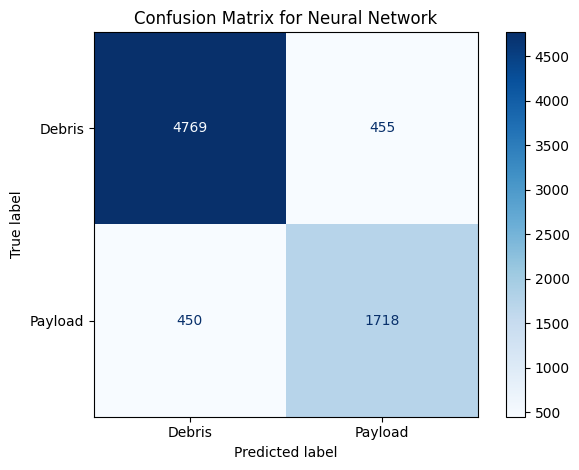

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_true, y_pred, *,
                     title="Confusion matrix",
                     labels=('Debris', 'Payload'),
                     filename="cm.png"):

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)

    disp.plot(values_format='d', cmap='Blues')
    plt.title(title)
    plt.tight_layout()

plot_conf_matrix(all_labels, all_preds, title="Confusion Matrix for Neural Network")
